**Advanced Machine Learning Final Project:**
**Group 2**
* Jake Machulcz
* Danielle Stealy
* Bridget Liesman
* Erich Haley

In [ ]:
# Import pulled from most recent HW
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import random
from sklearn.metrics import (
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score,
    accuracy_score
)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, \
  Embedding, TextVectorization, Dropout, Input, GRU
from tensorflow.keras.callbacks import EarlyStopping

#Included to get rid of tensorflow info logs
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from wordcloud import WordCloud

SEED = 1842

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
import tensorflow as tf
tf.keras.utils.set_random_seed(1)

tf.config.experimental.enable_op_determinism()

**Problem Definition** 
* Brief markdown: fictional scenario (who you are, why you care about this classification).
* Define binary outcome and how you map AG News labels to it.
* Choose metric(s): accuracy (main), maybe F1.

The code I have below is using all 4 categories (World, Sports, Business, Sci/Tech). We need to define a Binary Problem per the instructions.  
We need to choose something like:  
* Sports Vs. Business
* Sci/Tech Vs. World
* (World + Business) Vs. (Sports +Sci/Tech)  

We need to then start building the story:  
* "We're building a model for a financial news app that filters out Business news Vs. everything else:"

**Data Loading & Cleaning**  
* Code tasks:
  * Filter and relabel dataset for your binary setup.
  *  Split into train/valid/test (you’ve already done this; just adapt to binary).
* Compute:
  *  class counts
  *  text length summaries
* Show:
  *  bar chart of class frequencies
  *  histogram of lengths
  *  2–3 example headlines per class

Load the AG's News Corpus dataset.

In [2]:
# Code provided by project description to obtain dataset

import tensorflow_datasets as tfds
train_data, test_data = tfds.load(
  'ag_news_subset',
  split = ['train', 'test'],
  batch_size = -1,
  as_supervised=True #Added this line to ensure the code worked
)

# Split the text and labels apart
train_reviews, train_labels = tfds.as_numpy(train_data)
test_reviews, test_labels = tfds.as_numpy(test_data)

In [3]:
# Clean a single text string
def clean_text_string(s: str) -> str:
    # Replace HTML-like artifacts (#39; -> ')
    s = s.replace("#39;", "'")
    
    # Lowercase
    s = s.lower()
    
    # Keep letters, numbers, punctuation (. ? ! ')
    s = re.sub(r"[^a-z0-9.?!' ]+", " ", s)
    
    # Strip leading/trailing apostrophes
    s = s.strip("'")
    
    # Fix possessives: " john 's " -> "john's"
    s = re.sub(r"\s+'", "'", s)
    
    return s

# Clean an array of byte strings or normal strings
def clean_text_array(arr):
    cleaned = []
    for t in arr:
        # If bytes, decode to string
        if isinstance(t, bytes):
            t = t.decode("utf-8", errors="ignore")
        cleaned.append(clean_text_string(t))
    return np.array(cleaned, dtype=object)



train_reviews_clean = clean_text_array(train_reviews)
test_reviews_clean  = clean_text_array(test_reviews)

print(train_reviews_clean[:3])
print(test_reviews_clean[:3])


["amd's new dual core opteron chip is designed mainly for corporate computing applications  including databases  web services  and financial transactions."
 'reuters   major league baseball monday announced a decision on the appeal filed by chicago cubs pitcher kerry wood regarding a suspension stemming from an incident earlier this season.'
 "president bush's  quot revenue neutral quot  tax reform needs losers to balance its winners  and people claiming the federal deduction for state and local taxes may be in administration planners' sights  news reports say."]
[' charlotte  n.c.  sports network    carolina panthers  running back stephen davis will miss the remainder of the  season after being placed on injured reserve saturday.'
 ' presentacion  philippines  reuters    philippine communist  rebels freed wednesday two soldiers they had held as  prisoners  of war  for more than five months  saying they wanted to  rebuild confidence in peace talks with the government.'
 "san francisco 

In [4]:
train_reviews_clean = clean_text_array(train_reviews)
test_reviews_clean  = clean_text_array(test_reviews)

In [5]:
# Filtering our dataset to only include the Categories we decide to pursue. Im using Bus and Sci just to set the code up.

Business = 2
SciTech  = 3

mask_train = np.isin(train_labels, [Business, SciTech])
mask_test  = np.isin(test_labels,  [Business, SciTech])


x_train_filtered = train_reviews_clean[mask_train]
y_train_filtered = train_labels[mask_train]


x_test_filtered  = test_reviews_clean[mask_test]
y_test_filtered  = test_labels[mask_test]

In [6]:
# Converting our labels to binary

label_map = {Business: 0, SciTech: 1}

y_train_bin = np.vectorize(label_map.get)(y_train_filtered)
y_test_bin  = np.vectorize(label_map.get)(y_test_filtered)

print("Unique training labels:", np.unique(y_train_bin))
print("Unique test labels:", np.unique(y_test_bin))

Unique training labels: [0 1]
Unique test labels: [0 1]


In [7]:
# Creating our Train/Validation Split
x_train, x_valid, y_train, y_valid = \
    train_test_split(x_train_filtered,  y_train_bin, test_size=0.3, stratify=y_train_bin, random_state=SEED)

#Final train, validation, and test set sizes
print('Text (train):', x_train.shape)
print('Text (validation):', x_valid.shape)
print('Text (test):', x_test_filtered.shape)
print('Labels (train):', y_train.shape)
print('Labels (validation):', y_valid.shape)
print('Labels (test):', y_test_filtered.shape)

Text (train): (42000,)
Text (validation): (18000,)
Text (test): (3800,)
Labels (train): (42000,)
Labels (validation): (18000,)
Labels (test): (3800,)


## EDA

In this section, we perform Exploratory Data Analysis (EDA) on the filtered AG News dataset to understand the characteristics of our categories of interest. We have already done some initial cleaning to focus on our categories of interest: 
* Business (label = 0)
* Sci/Tech (label = 1)

Additionally, per data science best-practices, our dataset has been split into testing and training sets and we will focus our EDA on the training set to avoid data leakage. 

### Class Balance

In order to ensure we do not have a majority class that dominates our models' predictions, we need to ensure there is balance in the two classes.

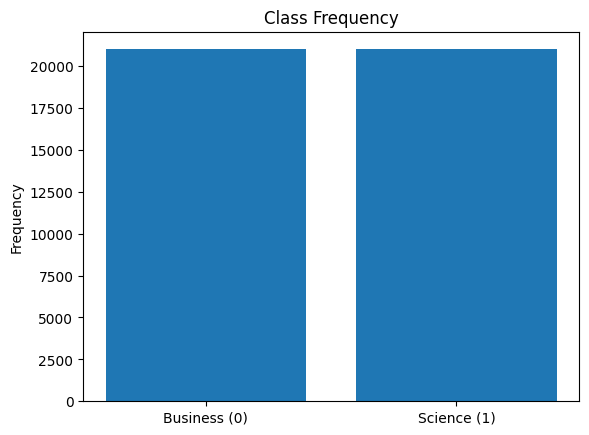

Business Count: 21000
Science Count: 21000


In [8]:
#Find counts for each class
n_bus = len(y_train) - sum(y_train)
n_sci = sum(y_train)

#Plot the counts of each class
plt.bar(['Business (0)', 'Science (1)'], [n_bus, n_sci])
plt.ylabel('Frequency')
plt.title('Class Frequency')
plt.show()

print('Business Count:', n_bus)
print('Science Count:', n_sci)

The classes are perfectly balanced in the training data, therefore we do not need to perform any over or undersampling.

### Vocabulary Analysis

In this section, we will determine how many words compose our corpus to help with setting a plausible max_token_size.

In [9]:
all_words = " ".join(x_train).split()
vocab_size = len(set(all_words))
print(vocab_size)

47930


We have a corpus of just under 82,000 words. Therefore we will want to set a max_token_size around 50,000 to ensure we have captured all the frequently used words.

### Text Length

This section will explore the distribution of the word counts for the text observations across the whole dataset as well as for each class to determine if there are any significant differences.

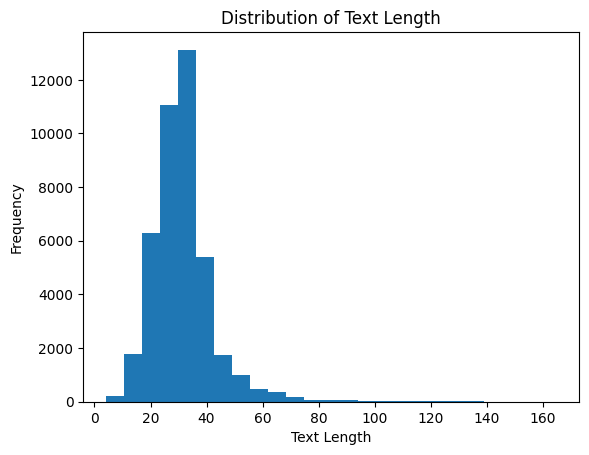

Average Length: 31.54
Median Length: 30.0
Max Length: 165
Min Length: 4
95th Percentile Length: 51.0


In [10]:
#get word counts
text_l = [len(x.split()) for x in x_train]

#plot the distribution
plt.hist(text_l, bins=25)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.show()

#print word count stats
print('Average Length:', round(np.mean(text_l),2))
print('Median Length:', np.median(text_l))
print('Max Length:', np.max(text_l))
print('Min Length:', np.min(text_l))
print('95th Percentile Length:', np.percentile(text_l, 95))

The text observations tend to be around 30 words long with a handful of very long observations. Our longest text observation is 163 words, with most words falling below 100, which means that our output_sequence_length does not need to exceed 100 and, in fact, could be around 45 and still cover 95% of the dataset. Next, let's see if there is any difference when exploring the distributions for each class.

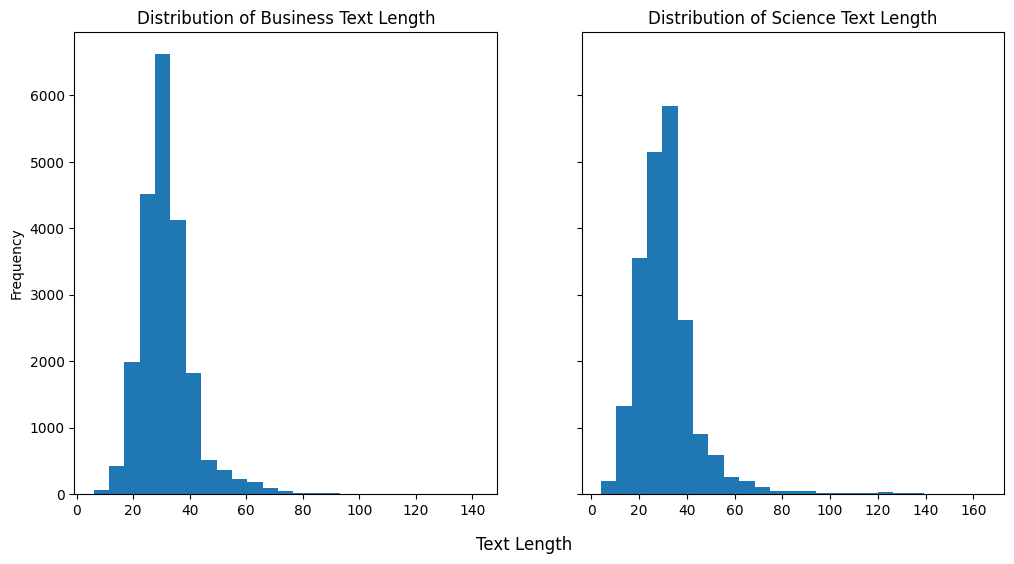

Business Average Length: 31.68
Business Median Length: 31.0
Business Max Length: 142
Business Min Length: 6


Science Average Length: 31.39
Science Median Length: 30.0
Science Max Length: 165
Science Min Length: 4


In [11]:
#get the text for each class
bus_text = x_train[y_train==0]
sci_text = x_train[y_train==1]

#get word counts
bus_text_l = [len(b.split()) for b in bus_text]
sci_text_l = [len(s.split()) for s in sci_text]

#plot the distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
axes[0].hist(bus_text_l, bins=25)
axes[0].set_title('Distribution of Business Text Length')
axes[0].set_ylabel('Frequency')
axes[1].hist(sci_text_l, bins=25)
axes[1].set_title('Distribution of Science Text Length')
fig.supxlabel('Text Length')

plt.show()

#print word count stats
print('Business Average Length:', round(np.mean(bus_text_l),2))
print('Business Median Length:', np.median(bus_text_l))
print('Business Max Length:', np.max(bus_text_l))
print('Business Min Length:', np.min(bus_text_l))
print('\n')
print('Science Average Length:', round(np.mean(sci_text_l),2))
print('Science Median Length:', np.median(sci_text_l))
print('Science Max Length:', np.max(sci_text_l))
print('Science Min Length:', np.min(sci_text_l))

Both classes tend to have texts of around 30 words in length. The Science texts have a longer right tail, showing that there are a handful of texts that skew longer, however generally, the distribution of the two classes' text lengths are similar

### Commonly Used Phrases

This section will focus on the commonly used phrases for each class to help us to better understand the makeup of the text observations for each data type.

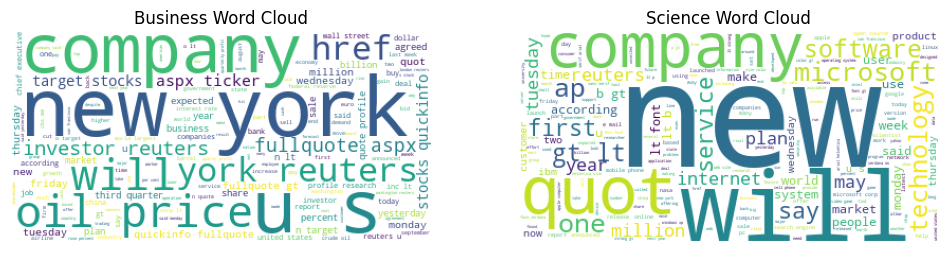

In [12]:
bus_text = " ".join(x_train[y_train == 0])
sci_text = " ".join(x_train[y_train == 1])

wc_bus = WordCloud(background_color="white").generate(bus_text)
wc_sci = WordCloud(background_color="white").generate(sci_text)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_bus); axes[0].axis("off"); axes[0].set_title("Business Word Cloud")
axes[1].imshow(wc_sci); axes[1].axis("off"); axes[1].set_title("Science Word Cloud")
plt.show()


The above wordcloud are the most commonly used words for the whole corpus, let's now explore the most commonly used words for each class.

Based on these word clouds, we can see some differences between the two classes, however there also is some noise, such as words like 'quot' and 'FullQuote' that come from the text settings, as well as words like the city and day of the week that tell us little about the actual topic. To filter these out, we will create word clouds using the TF-IDF values instead of the word frequencies.

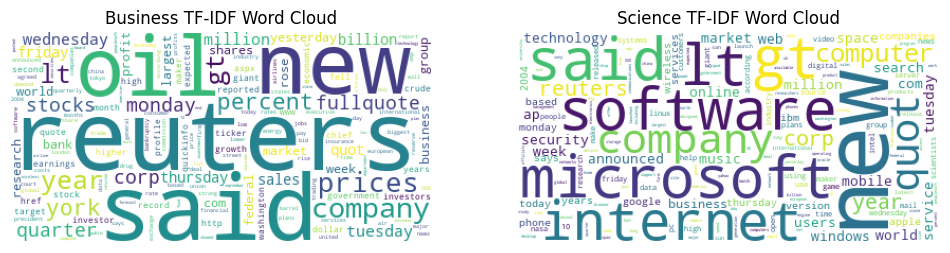

In [13]:
# Use the individual documents, not the giant joined string
bus_docs = x_train[y_train == 0]
sci_docs = x_train[y_train == 1]

# Create vectorizers
vectorizer_b = TfidfVectorizer(stop_words='english')
vectorizer_s = TfidfVectorizer(stop_words='english')

# Fit on the class-specific documents
tfidf_vals_b = vectorizer_b.fit_transform(bus_docs)
tfidf_vals_s = vectorizer_s.fit_transform(sci_docs)

# Extract vocabulary
words_b = vectorizer_b.get_feature_names_out()
words_s = vectorizer_s.get_feature_names_out()

# Average tfidf across all docs in the class
avg_tfidf_b = np.asarray(tfidf_vals_b.mean(axis=0)).flatten()
avg_tfidf_s = np.asarray(tfidf_vals_s.mean(axis=0)).flatten()

# Convert to dict for WordCloud
tfidf_b = dict(zip(words_b, avg_tfidf_b))
tfidf_s = dict(zip(words_s, avg_tfidf_s))

# Create word clouds
wc_b2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_b)
wc_s2 = WordCloud(background_color="white").generate_from_frequencies(tfidf_s)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc_b2); axes[0].axis("off"); axes[0].set_title("Business TF-IDF Word Cloud")
axes[1].imshow(wc_s2); axes[1].axis("off"); axes[1].set_title("Science TF-IDF Word Cloud")
plt.show()


# This section (#4) - we should discuss

## 4. Example of News Articles

In [14]:
def show_examples(x, y, label_name, n=3):
    idx = np.where(y == label_name)[0]
    sample_idx = np.random.choice(idx, n, replace=False)

    for i in sample_idx:
        print(f"\n--- Example (Label={label_name}) ---")
        print(x[i])

show_examples(x_train, y_train, 0)  # Business
show_examples(x_train, y_train, 1)  # Sci/Tech


--- Example (Label=0) ---
a us appeals court has upheld a ruling that research in motion  the maker of blackberry pagers  engaged in patent infringement  but it gave the company a chance to reduce a jury award that has grown to more than  100 million with interest.

--- Example (Label=0) ---
invesco funds group inc. and two other mutual fund units of amvescap llc will pay  375 million to settle securities and exchange commission charges 

--- Example (Label=0) ---
london   according to a correspondent in taiwan morris chang  chairman of taiwan semiconductor manufacturing co. ltd. had some interesting things to say about the outlook following on from the company's third quarter results.

--- Example (Label=1) ---
headisdead writes  quot this bbc report has details of the iosn's  international open source network  role in yesterday's software freedom day.

--- Example (Label=1) ---
space.com   astronomers  have pieced together what  appears to be the first direct evidence that solar sto

### EDA Summary

The EDA section explored the dataset as a whole, as well as split between the two classes. We found that the two classes are balanced and that they tend to have similar distributions of word lengths. This means that we do not need to perform any further data cleaning to ensure there is no minority/majority classes. Additionally, our models should not be skewed from differences in the structure of the text values. 

One interesting take away from the EDA section is that, despite splitting between the texts between Business and Science, actual business names dominate the word frequencies, with Reuters and Microsoft showing up with top TF-IDF values in Business and Science respectively. This may pose some difficulty in our models as text statements may focus on Science/Technology, but have business perspective.

The EDA also helped to provide starting values for our max_tokens and output_sequence_length. Since the corpus is comprised of around 82,000 words, we can initially set our max_tokens to be around 50,000 to account for the majority of frequently used words. Our text lengths are all below 165 words, with 95% of observations falling below 45 words, therefore we can initially set our output_sequence_length to be around 50. These values may change as we test and refine the models, but are helpful baseline values.

Our data exploration also revealed the types of models we should use. Our sequences range from 3 to 163 tokens with the great majority of data falling below the 50 token length, therefore they are not too long for RNN models. They could be a bit short for LSTM and GRU, however our trainig dataset has over 40,000 observations with a corpus of around 82,000 words, which is better handled by LSTM and GRU. Additionally, these text observations can include important information anywhere in the sequence and therefore LSTM and GRU may be helpful for parsing meaning across the entire the text observation. 

**Baseline Model (Classical ML)**  
* Code tasks:
    * Build TfidfVectorizer + SVM (or LogisticRegression, or RandomForest).
    * Fit on training set, evaluate on validation & test sets.

* Save:
    * validation accuracy
    * test accuracy
    * confusion matrix
    * classification report (precision/recall/F1).

In [15]:
print(type(x_train[0]), x_train[0][:80]) 


baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(max_features=20000, ngram_range=(1, 2))),
    ("clf", LogisticRegression(max_iter=200))
])


baseline_clf.fit(x_train, y_train)


y_test_pred  = baseline_clf.predict(x_test_filtered)
y_test_proba = baseline_clf.predict_proba(x_test_filtered)[:, 1]

acc = accuracy_score(y_test_bin, y_test_pred)
conf_mat = confusion_matrix(y_test_bin, y_test_pred, labels=[0, 1])
tn, fp, fn, tp = conf_mat.ravel()
rec = recall_score(y_test_bin, y_test_pred)
prec = precision_score(y_test_bin, y_test_pred)
fpr = fp / (fp + tn)
fdr = fp / (fp + tp)
roc = roc_auc_score(y_test_bin, y_test_proba)

print("Accuracy:", round(acc, 2))
print("Confusion matrix:\n", conf_mat)
print("Recall:", round(rec, 2))
print("Precision:", round(prec, 2))
print("FPR:", round(fpr, 2))
print("FDR:", round(fdr, 2))
print("ROC AUC:", round(roc, 2))

<class 'str'> the supreme court ended monday the telemarketing industry's attempt to abolish t
Accuracy: 0.9
Confusion matrix:
 [[1689  211]
 [ 165 1735]]
Recall: 0.91
Precision: 0.89
FPR: 0.11
FDR: 0.11
ROC AUC: 0.96


In [16]:
val_acc = baseline_clf.score(x_valid, y_valid)
print("Validation Accuracy:", round(val_acc, 2))

Validation Accuracy: 0.91


We trained a baseline text classification model using a TF-IDF vectorizer (20,000 max features, bigrams included) paired with Logistic Regression.

The baseline model performed extremely well, achieving 91% validation accuracy and 90% test accuracy, with an AUC of 0.96.

The confusion matrix shows balanced performance across classes:
Business (label=0) and Sci/Tech (label=1) are both predicted with high recall (0.91) and precision (0.89).

These results indicate that the vocabulary-level differences between the two news categories are strong and largely linearly separable. As such, TF-IDF + Logistic Regression provides a robust foundation and a challenging baseline for comparison with the deep learning models (Simple RNN, LSTM, GRU).

**Deep Learning Models (RNN/LSTM/GRU)**    
* We already have SimpleRNN. Now:
1. Reuse our vectorization & splits for the binary labels.  
2. Train:  
    * RNN (done, just adapt to binary if needed)  
    * LSTM  
    *  GRU  

In [17]:
x_train_tf = tf.constant(x_train, dtype=tf.string)
x_valid_tf = tf.constant(x_valid, dtype=tf.string)
x_test_tf  = tf.constant(x_test_filtered, dtype=tf.string)

y_train_tf = tf.constant(y_train, dtype=tf.int32)
y_valid_tf = tf.constant(y_valid, dtype=tf.int32)
y_test_tf  = tf.constant(y_test_bin, dtype=tf.int32)

print(x_train_tf.shape, x_valid_tf.shape, x_test_tf.shape)
print(y_train_tf.shape, y_valid_tf.shape, y_test_tf.shape)

print("Train labels:", np.unique(y_train_tf.numpy()))
print("Valid labels:", np.unique(y_valid_tf.numpy()))
print("Test labels:",  np.unique(y_test_tf.numpy()))

(42000,) (18000,) (3800,)
(42000,) (18000,) (3800,)
Train labels: [0 1]
Valid labels: [0 1]
Test labels: [0 1]


# Update max_tokens and max_sequence_length to match EDA or update EDA to match here

In [27]:
max_tokens = 20000
max_sequence_length = 200
vectorized = TextVectorization(
    max_tokens=max_tokens,  
    output_sequence_length=max_sequence_length
)
vectorized.adapt(x_train_tf)

## 1. Simple RNN Model

In [28]:
embedding_dims = 32 
K = 16

model_rnn = Sequential()
model_rnn.add(Input(shape=(1,), dtype='string'))
model_rnn.add(vectorized)
model_rnn.add(Embedding(max_tokens + 1, embedding_dims))
model_rnn.add(SimpleRNN(K, return_sequences=False))
model_rnn.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model_rnn.add(Dropout(.5))
model_rnn.add(Dense(1, activation='sigmoid'))
model_rnn.summary()





Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 16)             │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 641,717 (2.45 MB)

 Trainable params: 641,717 (2.45 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model_rnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_rnn_history = model_rnn.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1024, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

rnn_test_loss, rnn_test_acc = model_rnn.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", rnn_test_acc)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6700 - loss: 0.7309 - val_accuracy: 0.7644 - val_loss: 0.6286
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.8199 - loss: 0.5544 - val_accuracy: 0.8128 - val_loss: 0.5355
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.8621 - loss: 0.4617 - val_accuracy: 0.8209 - val_loss: 0.5193
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.8781 - loss: 0.4123 - val_accuracy: 0.7826 - val_loss: 0.6057
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9050 - loss: 0.3485 - val_accuracy: 0.8144 - val_loss: 0.5443
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9074 - loss: 0.3314 - val_accuracy: 0.8104 - val_loss: 0.5542
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9024 - loss: 0.3378 - val_accuracy: 0.8012 - val_loss: 0.5593
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.9141 - loss: 0.3073 - val_accuracy: 0.8253 - v

## 2. LSTM Model

In [25]:
embedding_dims = 32 
K = 16

model = Sequential()
model.add(Input(shape=(1,), dtype='string'))
model.add(vectorized)
model.add(Embedding(max_tokens + 1, embedding_dims))
model.add(LSTM(K, return_sequences=False))
model.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model.add(Dropout(.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_history = model.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1024, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

test_loss, test_acc = model.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", test_acc)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 644,069 (2.46 MB)

 Trainable params: 644,069 (2.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 197ms/step - accuracy: 0.4975 - loss: 0.7967 - val_accuracy: 0.5000 - val_loss: 0.7808
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.4978 - loss: 0.7678 - val_accuracy: 0.5000 - val_loss: 0.7542
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.4980 - loss: 0.7435 - val_accuracy: 0.5000 - val_loss: 0.7326
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 169ms/step - accuracy: 0.5005 - loss: 0.7245 - val_accuracy: 0.5000 - val_loss: 0.7164
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 167ms/step - accuracy: 0.5005 - loss: 0.7106 - val_accuracy: 0.5000 - val_loss: 0.7046
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.5001 - loss: 0.7005 - val_accuracy: 0.5000 - val_loss: 0.6968
Epoch 7/50
30/42 ━━━━━━━━━━━━━━━━━━━━ 1s 152ms/step - accuracy: 0.4979 - loss: 0.6960

KeyboardInterrupt: 

In [19]:
embedding_dims = 8
K = 16 

model_lstm = Sequential()
model_lstm.add(Input(shape=(1,), dtype='string'))
model_lstm.add(vectorized)
model_lstm.add(Embedding(max_tokens + 1, embedding_dims))
model_lstm.add(LSTM(K, return_sequences=False))
model_lstm.add(Dense(64, activation='relu'))
#model_lstm.add(Dropout(.5))
model_lstm.add(Dense(1, activation='sigmoid'))
model_lstm.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 200, 8)         │       160,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,761 (635.79 KB)

 Trainable params: 162,761 (635.79 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping_lstm = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

model_lstm_history  = model_lstm.fit(x_train_tf, y_train_tf, epochs=50, batch_size=1050, 
          validation_data=(x_valid_tf, y_valid_tf))

lstm_test_loss, lstm_test_acc = model_lstm.evaluate(x_test_tf, y_test_tf, verbose=0)
print("LSTM Test Accuracy:", lstm_test_acc)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 184ms/step - accuracy: 0.4981 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 0.4976 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 0.4984 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.4987 - loss: 0.6932 - val_accuracy: 0.

KeyboardInterrupt: 

In [ ]:
lstm_test_loss, lstm_test_acc = model_lstm.evaluate(x_test_tf, y_test_tf, verbose=0)
print("LSTM Test Accuracy:", lstm_test_acc)

LSTM Test Accuracy: 0.5


## 3. GRU Model

In [25]:
embedding_dims = 32 

model_gru = Sequential()
model_gru.add(Input(shape=(1,), dtype='string'))
model_gru.add(vectorized)
model_gru.add(Embedding(max_tokens + 1, embedding_dims))
model_gru.add(GRU(32, return_sequences=False)) # K
model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(.5))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.summary()


model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model_gru.fit(x_train_tf, y_train_tf, epochs=30, batch_size=4000, 
          validation_data=(x_valid_tf, y_valid_tf))

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 200, 32)        │       640,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 32)             │         6,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 648,545 (2.47 MB)

 Trainable params: 648,545 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 9s 643ms/step - accuracy: 0.4966 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 7s 603ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/30
 5/11 ━━━━━━━━━━━━━━━━━━━━ 3s 561ms/step - accuracy: 0.4987 - loss: 0.6933

KeyboardInterrupt: 

In [ ]:
gru_test_loss, gru_test_acc = model_gru.evaluate(x_test_tf, y_test_tf, verbose=0)
print("GRU Test Accuracy:", gru_test_acc)

GRU Test Accuracy: 0.5


**Model Comparison & Discussion**
* Create a table to professionally report the results
    * Brief markdown discussing:
    * which model performs best
    * tradeoffs (complexity, training time, ease of deployment)
    * any overfitting / underfitting patterns you see from curves.

In [ ]:
#results = [
#    ("SVM TF-IDF", svm_valid_acc, svm_test_acc),
#    ("SimpleRNN", rnn_valid_acc, rnn_test_acc),
#    ("LSTM", lstm_valid_acc, lstm_test_acc),
#    ("GRU", gru_valid_acc, gru_test_acc),
#]

#results_df = pd.DataFrame(
#    results,
#    columns=["Model", "Validation Accuracy", "Test Accuracy"]
#)

#results_df

In [23]:
embedding_dims = 8 
K = 16

model_gru = Sequential()
model_gru.add(Input(shape=(1,), dtype='string'))
model_gru.add(vectorized)
model_gru.add(Embedding(max_tokens + 1, embedding_dims))
model_gru.add(GRU(K, return_sequences=False))
model_gru.add(Dense(50, activation='relu',
                kernel_regularizer=keras.regularizers.l1(.001)))
model_gru.add(Dropout(.5))
model_gru.add(Dense(1, activation='sigmoid'))
model_gru.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 8)         │       160,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 16)             │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │           850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 162,157 (633.43 KB)

 Trainable params: 162,157 (633.43 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
model_gru.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

model_gru_history = model_gru.fit(x_train_tf, y_train_tf, epochs=20, batch_size=500, 
          validation_data=(x_valid_tf, y_valid_tf),
          callbacks=[early_stopping])

gru_test_loss, gru_test_acc = model_gru.evaluate(x_test_tf, y_test_tf, verbose=0)
print("RNN Test Accuracy:", gru_test_acc)

Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step - accuracy: 0.4977 - loss: 0.7829 - val_accuracy: 0.5000 - val_loss: 0.7550
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4985 - loss: 0.7346 - val_accuracy: 0.5000 - val_loss: 0.7166
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4939 - loss: 0.7055 - val_accuracy: 0.5000 - val_loss: 0.6969
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4953 - loss: 0.6941 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.5020 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4963 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.5036 - loss: 0.6932 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 84ms/step - accuracy: 0.4986 - loss: 0.6933 - val_accuracy: 0.5000 - v

KeyboardInterrupt: 